# Step 3: Add an ML pipeline

In this step you automate our end-to-end ML workflow using [Amazon SageMaker Pipelines](https://aws.amazon.com/sagemaker/pipelines/) and [Amazon SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html). You make feature engineering re-usable, repeatable, and scaleable using [Amazon SageMaker Feature Store](https://aws.amazon.com/sagemaker/feature-store/).

![](img/six-steps-3.png)

<div class="alert alert-info"> Make sure you using <code>Python 3</code> kernel in JupyterLab for this notebook.</div>

In [ ]:
# To get the Feature Processor module, we need to reinstall the SageMaker python SDK along with extra dependencies
%pip install 'sagemaker[feature-processor]' --force-reinstall

In [ ]:
%pip install -q s3fs

In [8]:
# Restart kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [85]:
import pandas as pd
import json
import boto3
import pathlib
import io
import sagemaker
import mlflow
from time import gmtime, strftime, sleep
from sagemaker.deserializers import CSVDeserializer
from sagemaker.serializers import CSVSerializer

from sagemaker.workflow.execution_variables import ExecutionVariables
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import (
    ProcessingInput, 
    ProcessingOutput, 
    ScriptProcessor
)
from sagemaker.inputs import TrainingInput

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import (
    ProcessingStep, 
    TrainingStep, 
    CreateModelStep,
    CacheConfig
)
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.parameters import (
    ParameterInteger, 
    ParameterFloat, 
    ParameterString, 
    ParameterBoolean
)
from sagemaker.workflow.quality_check_step import (
    DataQualityCheckConfig,
    ModelQualityCheckConfig,
    QualityCheckStep,
)
from sagemaker.workflow.clarify_check_step import (
    ModelBiasCheckConfig, 
    ClarifyCheckStep, 
    ModelExplainabilityCheckConfig
)
from sagemaker import Model
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.conditions import (
    ConditionGreaterThan,
    ConditionGreaterThanOrEqualTo
)
from sagemaker.workflow.parallelism_config import ParallelismConfiguration
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import (
    Join,
    JsonGet
)
from sagemaker.workflow.lambda_step import (
    LambdaStep,
    LambdaOutput,
    LambdaOutputTypeEnum,
)
from sagemaker.lambda_helper import Lambda

from sagemaker.model_metrics import (
    MetricsSource, 
    ModelMetrics, 
    FileSource
)
from sagemaker.drift_check_baselines import DriftCheckBaselines
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig 
from sagemaker.image_uris import retrieve
from sagemaker.workflow.function_step import step
from sagemaker.workflow.step_outputs import get_step
from sagemaker.model_monitor import DatasetFormat, model_monitoring

sagemaker.__version__

'2.224.4'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
baseline_s3_url                     -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
bucket_name                         -> 'sagemaker-us-east-1-906545278380'
bucket_prefix                       -> 'from-idea-to-prod/xgboost'
dataset_file_local_path             -> 'data/bank-additional/bank-additional-full.csv'
domain_id                           -> 'd-1dklekwofndh'
experiment_name                     -> 'from-idea-to-prod-experiment-06-19-57-57'
initialized                         -> True
input_s3_url                        -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
mlflow_arn                          -> 'arn:aws:sagemaker:us-east-1:906545278380:mlflow-t
output_s3_url                       -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
region                              -> 'us-east-1'
sm_role                             -> 'arn:aws:iam::906545278380:role/service-role/Amazo
space_name                          -> 'mlops-wo

## Set constants

In [4]:
# Set names of pipeline objects, experiment, and a model
project = "from-idea-to-prod"

current_timestamp = strftime('%d-%H-%M-%S', gmtime())

registered_model_name = f"{project}-pipeline-model-{current_timestamp}"
experiment_name = f"{project}-pipeline-{current_timestamp}"
pipeline_name = f"{project}-pipeline-{current_timestamp}"
pipeline_model_name = f"{project}-model-xgb"
model_package_group_name = registered_model_name
endpoint_config_name = f"{project}-endpoint-config"
endpoint_name = f"{project}-endpoint"
model_approval_status = "PendingManualApproval"

In [5]:
# Set instance types and counts
process_instance_type = "ml.m5.large"
train_instance_type = "ml.m5.xlarge"

In [6]:
# Set S3 urls for various datasets produced in the pipeline
output_s3_prefix = f"s3://{bucket_name}/{bucket_prefix}"
output_s3_url = f"{output_s3_prefix}/output"

train_s3_url = f"{output_s3_prefix}/train"
validation_s3_url = f"{output_s3_prefix}/validation"
test_s3_url = f"{output_s3_prefix}/test"
evaluation_s3_url = f"{output_s3_prefix}/evaluation"

baseline_s3_url = f"{output_s3_prefix}/baseline"
baseline_results_s3_url = f"{baseline_s3_url}/results"

prediction_baseline_s3_url = f"{output_s3_prefix}/prediction_baseline"
prediction_baseline_results_s3_url=f"{prediction_baseline_s3_url}/results"

In [7]:
xgboost_image_uri = sagemaker.image_uris.retrieve(
            "xgboost", 
            region=boto3.Session().region_name,
            version="1.5-1"
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [8]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url
%store pipeline_name
%store model_package_group_name
%store evaluation_s3_url
%store prediction_baseline_s3_url
%store output_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)
Stored 'pipeline_name' (str)
Stored 'model_package_group_name' (str)
Stored 'evaluation_s3_url' (str)
Stored 'prediction_baseline_s3_url' (str)
Stored 'output_s3_url' (str)


In [9]:
print(f"Train S3 url: {train_s3_url}")
print(f"Validation S3 url: {validation_s3_url}")
print(f"Test S3 url: {test_s3_url}")
print(f"Data baseline S3 url: {baseline_s3_url}")
print(f"Evaluation metrics S3 url: {evaluation_s3_url}")
print(f"Model prediction baseline S3 url: {prediction_baseline_s3_url}")

Train S3 url: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/train
Validation S3 url: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/validation
Test S3 url: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/test
Data baseline S3 url: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/baseline
Evaluation metrics S3 url: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/evaluation
Model prediction baseline S3 url: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/prediction_baseline


## Define helper functions
Define some shorthand functions for better code readability.

In [10]:
def get_xgb_estimator(
    session,
    instance_type,
    output_s3_url,
    base_job_name,
):
    # Instantiate an XGBoost estimator object
    estimator = sagemaker.estimator.Estimator(
        image_uri=xgboost_image_uri,
        role=sagemaker.get_execution_role(), 
        instance_type=instance_type,
        instance_count=1,
        output_path=output_s3_url,
        sagemaker_session=session,
        base_job_name=base_job_name
    )
    
    # Define algorithm hyperparameters
    estimator.set_hyperparameters(
        num_round=100, # the number of rounds to run the training
        max_depth=3, # maximum depth of a tree
        eta=0.5, # step size shrinkage used in updates to prevent overfitting
        alpha=2.5, # L1 regularization term on weights
        objective="binary:logistic",
        eval_metric="auc", # evaluation metrics for validation data
        subsample=0.8, # subsample ratio of the training instance
        colsample_bytree=0.8, # subsample ratio of columns when constructing each tree
        min_child_weight=3, # minimum sum of instance weight (hessian) needed in a child
        early_stopping_rounds=10, # the model trains until the validation score stops improving
        verbosity=1, # verbosity of printing messages
    )

    return estimator

## Configure MLflow

In [11]:
mlflow.set_tracking_uri(mlflow_arn)
experiment = mlflow.set_experiment(experiment_name=experiment_name)

2024/07/08 08:30:32 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-pipeline-08-08-30-16' does not exist. Creating a new experiment.


## Configure defaults for AWS infrastructure
You can use YAML configuration file to define the default values that are automatically passed to SageMaker APIs, for example as job parameters. It's especially convenient when you need to provide static parameters for infrastructure settings, such as VPC ids, Security Groups, KMS keys etc, or work with remote functions.

Refer to [Configuring and using defaults with the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk) documentation for examples and more details.

Your SageMaker pipeline will use these `config.yaml` files.

In [12]:
# Print default location of configuration files
import os
from platformdirs import site_config_dir, user_config_dir

#Prints the location of the admin config file
print(os.path.join(site_config_dir("sagemaker"), "config.yaml"))

#Prints the location of the user config file
print(os.path.join(user_config_dir("sagemaker"), "config.yaml"))

/etc/xdg/sagemaker/config.yaml
/home/sagemaker-user/.config/sagemaker/config.yaml


The next cell creates a configuration file and sets default values for remote functions. These values are automatically passed to `@step` decorator and you don't need to specify them explicitly. Refer to [Configure your pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-cfg-pipeline.html) in the Developer Guide.

In [13]:
%%writefile config.yaml

SchemaVersion: '1.0'
SageMaker:
    PythonSDK:
        Modules:
            RemoteFunction:
                InstanceType: ml.m5.xlarge
                Dependencies: ./requirements.txt
                IncludeLocalWorkDir: true
                CustomFileFilter:
                    IgnoreNamePatterns: # files or directories to ignore
                        - "*.ipynb" # all notebook files
                        - "*.md" # all markdown files
                        - "__pycache__"

Writing config.yaml


In [14]:
# copy the configuration file to user config file location
%mkdir -p {user_config_dir("sagemaker")}
%cp config.yaml {os.path.join(user_config_dir("sagemaker"), "config.yaml")}

## Prepare environment

In [15]:
# Install xgboost for the local testing of the code
%pip install -q xgboost

Note: you may need to restart the kernel to use updated packages.


Create a `requirement.txt` file for the pipeline environment that will be used by your SageMaker pipeline:

In [77]:
%%writefile requirements.txt
scikit-learn
pandas>=2.0.0
s3fs==0.4.2
sagemaker
xgboost
mlflow==2.13.2
sagemaker-mlflow==0.1.0

Overwriting requirements.txt


## A SageMaker pipeline

### Setup pipeline parameters
SageMaker Pipelines supports [parameterization](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html), which allows you to specify input parameters at runtime without changing your pipeline code. You can use the parameter classes available under the [`sagemaker.workflow.parameters`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#parameters) module.
Parameters have a default value, which you can override by specifying parameter values when starting a pipeline execution.

In [35]:
# Set processing instance type
process_instance_type_param = ParameterString(
    name="ProcessingInstanceType",
    default_value=process_instance_type,
)

# Set training instance type
train_instance_type_param = ParameterString(
    name="TrainingInstanceType",
    default_value=train_instance_type,
)

# Set model approval status for the model registry
model_approval_status_param = ParameterString(
    name="ModelApprovalStatus",
    default_value=model_approval_status
)

# Minimal threshold for model performance on the test dataset
test_score_threshold_param = ParameterFloat(
    name="TestScoreThreshold",
    default_value=0.75
)

# Parametrize the S3 url for input dataset
input_s3_url_param = ParameterString(
    name="InputDataUrl",
    default_value=input_s3_url,
)

# Model package group name
model_package_group_name_param = ParameterString(
    name="ModelPackageGroupName",
    default_value=model_package_group_name,
)

# MLflow tracking server ARN
tracking_server_arn_param = ParameterString(
    name="TrackingServerARN",
    default_value=mlflow_arn,
)

### Implement and test the pipeline steps
You create a pipeline with the following:
| Step | Description |
|---|---|
| **Data processing** | runs a SageMaker processing job for feature engineering and dataset split|
| **Training** | runs a SageMaker training job using XGBoost algorithm |
| **Evaluation** | evaluates the performance of the trained model |
| **Conditional step** | checks if the performance of the model meets the specified threshold |
| **Register model** | registers a version of the model in the SageMaker model registry |

To facilitate implementation of your pipeline as code you're going to use two useful features of SageMaker: Subclass compatibility and @step decorator.

#### Subclass compatibility
💡 You can use subclass compatibility for [workflow pipeline job steps](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#steps) to build job abstractions and use exactly the same code to configure the pipeline as the code for running processing, training, transform, and tuning jobs from the previous step notebooks. You need to use [PipelineSession](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.pipeline_context.PipelineSession) context instead of `sagemaker_session` to capture the run calls such as `processor.run()` or `estimator.fit()` but not run until the pipeline is created and executed.

#### @step decorator
💡 You can lift-and-shift your existing Python code to SageMaker pipelines. You can also use Python functions to implement an ML workflow using SageMaker Python SDK and test all code locally in the notebook. When you want to create a pipeline, you can use the SageMaker Python SDK [`@step`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#step-decorator) decorator to convert Python functions into pipeline steps. Refer to the SageMaker [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-create-pipeline.html) for more details and examples.

The following code uses Python functions to implement workflow steps, test them locally, and then apply `@step` decorator to re-use the function as a pipeline step.

#### Limitations with @step decorator
Be aware of the specific [limitations](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-limit.html) when you use `@step` decorator for pipeline steps.

Start developing and testing steps in the following code cells.

#### Processing step
Re-use the Python function local code from the step 2 [notebook](./02-sagemaker-containers.ipynb) and create a `preprocess` function in the `./pipeline_steps` folder. You're going to use this function to create a pipeline processing step.

In [17]:
# Python function code is in the local files
from pipeline_steps.preprocess import preprocess

In [18]:
# See the function code
# !pygmentize pipeline_steps/preprocess.py

In [19]:
# check that there is dataset under S3 url
!aws s3 ls {input_s3_url}

2024-07-06 20:09:39    5834924 bank-additional-full.csv


In [20]:
# You can run your Python code locally and verify the corectness before constructing a pipeline
r_preprocess = preprocess(
    input_data_s3_path=input_s3_url,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=mlflow_arn,
    experiment_name=f"local-test-{current_timestamp}"
)
r_preprocess

2024/07/08 08:42:30 INFO mlflow.tracking.fluent: Experiment with name 'local-test-08-08-30-16' does not exist. Creating a new experiment.
/opt/conda/lib/python3.10/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/input/bank-additional-full.csv'. Exception: 
  return _dataset_source_registry.resolve(
/opt/conda/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles 

## Data split > train:(28831, 65) | validation:(8238, 65) | test:(4119, 65)
## Data processing complete. Exiting.


{'train_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/train/train.csv',
 'validation_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/validation/validation.csv',
 'test_x_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/test/test_x.csv',
 'test_y_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/test/test_y.csv',
 'baseline_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/baseline/baseline.csv',
 'experiment_name': 'local-test-08-08-30-16',
 'pipeline_run_id': ''}

In [21]:
# check that the function generated output
!aws s3 ls {output_s3_prefix}/test/

2024-07-08 08:42:52     600465 test_x.csv
2024-07-08 08:42:52       8238 test_y.csv


#### Training step
First, run a model training remotely as a SageMaker built-in algorithm training job. 

Second, use the trained model to test the evaluation script as a local Python function.

Third, use this Python function to construct an evaluation step in the pipeline.

In [22]:
# use sagemaker.Session() in the estimator to a training job immediately
estimator = get_xgb_estimator(
    session=sagemaker.Session(),
    instance_type=train_instance_type,
    output_s3_url=output_s3_url,
    base_job_name=f"{project}-train",
)

sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [23]:
# Set up the training inputs using the outputs from preprocess function
training_inputs = {
    "train": TrainingInput(
        r_preprocess['train_data'],
        content_type="text/csv",
    ),
    "validation": TrainingInput(
        r_preprocess['validation_data'],
        content_type="text/csv",
    ),
}

The next code cell fits the estimator. Wait less than 3 minutes until the training job finishes. Note that the code also logs the trained model into MLflow model registry.

In [24]:
from pipeline_steps.evaluate import load_model

# Run the training job
mlflow.set_experiment(r_preprocess['experiment_name'])
with mlflow.start_run(
    run_name=f"training-{strftime('%d-%H-%M-%S', gmtime())}",
    description="training in the notebook 03 with a training job") as run:
    mlflow.log_params(estimator.hyperparameters())
    
    estimator.fit(training_inputs)

    mlflow.log_param("training job name", estimator.latest_training_job.name)
    mlflow.log_metrics({i['metric_name'].replace(':', '_'):i['value'] for i in estimator.training_job_analytics.dataframe().iloc})
    mlflow.xgboost.log_model(load_model(estimator.model_data), artifact_path="xgboost")

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-train-2024-07-08-08-44-10-594


2024-07-08 08:44:11 Starting - Starting the training job...
2024-07-08 08:44:26 Starting - Preparing the instances for training...
2024-07-08 08:44:50 Downloading - Downloading input data...
2024-07-08 08:45:20 Downloading - Downloading the training image...
2024-07-08 08:46:01 Training - Training image download completed. Training in progress../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-07-08 08:46:08.474 ip-10-0-216-151.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-07-08 08:46:08.495 ip-10-0-216-151.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-07-08:08:46:08:INFO] Imported framework sagemaker_xgboost_container.training
[2024-07-08:08:46:08:INFO] Failed to parse hyperparameter eval_metric value auc t

Training seconds: 95
Billable seconds: 95


2024/07/08 08:46:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpxqhm3tz8/model, flavor: xgboost). Fall back to return ['xgboost==1.7.6']. Set logging level to DEBUG to see the full traceback. 
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### Evaluation step
Create a model evaluation script as a local Python function to check if the model performance meets the specified threshold. The Python code is in the file `evaluate.py` in the `./pipeline_steps` folder.

In [25]:
from pipeline_steps.evaluate import evaluate

In [26]:
# !pygmentize  pipeline_steps/evaluation.py

In [27]:
# check that the training job you've just run created a model file
!aws s3 ls {estimator.model_data}

2024-07-08 08:46:21       4962 model.tar.gz


Now load the trained model in the evaluation script and verify that the script executes correctly. Note the usage of output parameters from the `preprocess` function and the model artifact from the training job.

{'evaluation_result': {'classification_metrics': {'auc_score': {'value': 0.7701863354037267}}},
 'prediction_baseline_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/prediction_baseline/prediction_baseline.csv',
 'experiment_name': 'local-test-08-08-30-16',
 'pipeline_run_id': ''}

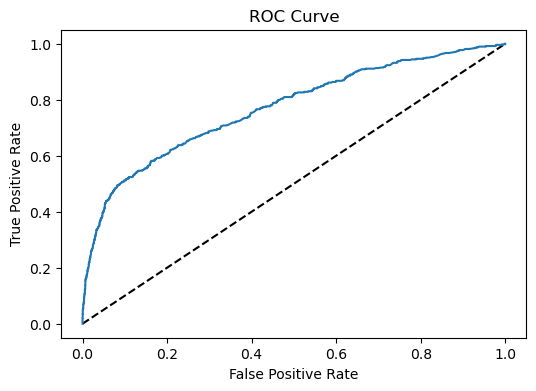

In [28]:
# Run the evaluation code locally
r_eval = evaluate(
    test_x_data_s3_path=r_preprocess['test_x_data'],
    test_y_data_s3_path=r_preprocess['test_y_data'],
    model_s3_path=estimator.model_data,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=mlflow_arn,
    experiment_name=r_preprocess['experiment_name'],
)
r_eval

In [29]:
# check that the evaluation function generated output
!aws s3 ls {output_s3_prefix}/prediction_baseline/

                           PRE reports/
                           PRE results/
2024-07-08 08:53:06      62730 prediction_baseline.csv


#### Model registration step
The register step creates a SageMaker model and registers a new version of a model in the SageMaker Model Registry within a [model package group](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-model-group.html). 
You implement this step also as a local Python function. The code is provided in the file `register.py` in the `./pipeline_steps` folder.

In [30]:
from pipeline_steps.register import register

In [31]:
# !pygmentize  pipeline_steps/register.py

In [32]:
# Run the model register code locally
r_register = register(
    training_job_name=estimator.latest_training_job.name,
    model_package_group_name=model_package_group_name,
    model_approval_status=model_approval_status,
    evaluation_result=r_eval['evaluation_result'],
    output_s3_prefix=output_s3_url,
    tracking_server_arn=mlflow_arn,
    experiment_name=r_preprocess['experiment_name'],
)
r_register


2024-07-08 08:46:25 Starting - Preparing the instances for training
2024-07-08 08:46:25 Downloading - Downloading the training image
2024-07-08 08:46:25 Training - Training image download completed. Training in progress.
2024-07-08 08:46:25 Uploading - Uploading generated training model
2024-07-08 08:46:25 Completed - Training job completed


{'model_package_arn': 'arn:aws:sagemaker:us-east-1:906545278380:model-package/from-idea-to-prod-pipeline-model-08-08-30-16/1',
 'model_package_group_name': 'from-idea-to-prod-pipeline-model-08-08-30-16',
 'pipeline_run_id': ''}

In [33]:
# check that a new model version has been registered in the model package group
boto3.client('sagemaker').describe_model_package(ModelPackageName=r_register['model_package_arn'])

{'ModelPackageGroupName': 'from-idea-to-prod-pipeline-model-08-08-30-16',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:906545278380:model-package/from-idea-to-prod-pipeline-model-08-08-30-16/1',
 'CreationTime': datetime.datetime(2024, 7, 8, 8, 54, 18, 331000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1',
    'ImageDigest': 'sha256:c764382b16cd0c921f1b2e66de8684fb999ccbd0c042c95679f0b69bc9cdd12c',
    'ModelDataUrl': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/output/from-idea-to-prod-train-2024-07-08-08-44-10-594/output/model.tar.gz',
    'Environment': {}}],
  'SupportedTransformInstanceTypes': ['ml.m5.xlarge', 'ml.m5.large'],
  'SupportedRealtimeInferenceInstanceTypes': ['ml.m5.xlarge', 'ml.m5.large'],
  'SupportedContentTypes': ['text/csv'],
  'SupportedResponseMIMETypes': ['text/csv']},
 'ModelPackageStatus': 'Completed',
 'ModelPack

### Construct a pipeline
After local testing you can use the same Python code without any changes to construct a pipeline.

The next cell creates a pipeline with previously developed and tested steps. Note, that you mix `@step`-decorated functions (preprocess, evaluate, register) and traditional pipeline steps (train) as SageMaker jobs in the same pipeline and pass data between them.

You don't need to manually define an ordering of the steps, as SageMaker automatically derives the processing flow based on data dependencies between pipeline's steps. You also don't need to manage transfer of artifacts and datasets from one pipeline's step to another, because SageMaker automatically takes care of the data flow.

Note the use of [`PipelineSession`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.pipeline_context.PipelineSession) instead of Session in the estimator object for the training step. When constructing a pipeline, a PipelineSession object must be given to the constructor of `Estimator` or `Processor` to start the job at pipeline execution time and not immedeately as with SageMaker `Session`.

In [36]:
# preprocess data step
step_preprocess = step(
    preprocess, 
    instance_type=process_instance_type_param,
    name=f"{project}-preprocess",
    keep_alive_period_in_seconds=3600,
)(
    input_data_s3_path=input_s3_url_param,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=tracking_server_arn_param,
    experiment_name=experiment_name,
    pipeline_run_name=ExecutionVariables.PIPELINE_EXECUTION_ID,
)

cache_config = CacheConfig(
        enable_caching=True,
        expire_after="P30d" # 30-day
    )

# train step
step_train = TrainingStep(
    name=f"{project}-train",
    step_args=get_xgb_estimator(
        session=PipelineSession(),
        instance_type=train_instance_type_param,
        output_s3_url=output_s3_url,
        base_job_name=f"{project}-train",
    ).fit(
        {
            "train": TrainingInput(
                step_preprocess['train_data'],
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                step_preprocess['validation_data'],
                content_type="text/csv",
            ),
        }
    ),
    cache_config=cache_config,
)    

# evaluate step
step_evaluate = step(
    evaluate,
    instance_type=process_instance_type_param,
    name=f"{project}-evaluate",
    keep_alive_period_in_seconds=3600,
)(
    test_x_data_s3_path=step_preprocess['test_x_data'],
    test_y_data_s3_path=step_preprocess['test_y_data'],
    model_s3_path=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=tracking_server_arn_param,
    experiment_name=step_preprocess['experiment_name'],
    pipeline_run_id=step_preprocess['pipeline_run_id'],
)

# register model step
step_register = step(
        register,
        name=f"{project}-register",
        keep_alive_period_in_seconds=3600,
    )(
        training_job_name=step_train.properties.TrainingJobName,
        model_package_group_name=model_package_group_name_param,
        model_approval_status=model_approval_status_param,
        evaluation_result=step_evaluate['evaluation_result'],
        output_s3_prefix=output_s3_url,
        tracking_server_arn=tracking_server_arn_param,
        experiment_name=step_preprocess['experiment_name'],
        pipeline_run_id=step_preprocess['pipeline_run_id'],
    )

# fail the pipeline execution step
step_fail = FailStep(
    name=f"{project}-fail",
    error_message=Join(on=" ", values=["Execution failed due to AUC Score < ", test_score_threshold_param]),
)

# condition to check in the condition step
condition_gte = ConditionGreaterThanOrEqualTo(
        left=step_evaluate['evaluation_result']['classification_metrics']['auc_score']['value'],  
        right=test_score_threshold_param,
)

# conditional register step
step_conditional_register = ConditionStep(
    name=f"{project}-check-metrics",
    conditions=[condition_gte],
    if_steps=[step_register],
    else_steps=[step_fail],
)

# Create a pipeline object
pipeline = Pipeline(
    name=f"{pipeline_name}",
    parameters=[
        input_s3_url_param,
        process_instance_type_param,
        train_instance_type_param,
        model_approval_status_param,
        test_score_threshold_param,
        model_package_group_name_param,
        tracking_server_arn_param,
    ],
    steps=[step_conditional_register],
    pipeline_definition_config=PipelineDefinitionConfig(use_custom_job_prefix=True)
)

/opt/conda/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


Note, we added two more steps to the pipeline: Fail step and Condition Step.

#### Fail step
A Pipelines [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) stops the pipeline execution if the model performance metric doesn't meet the specified threshold. 

#### Condition step
The condition step checks the model performance score calculated in the evaluation step and conditionally creates a model and registers it in the model registry, or stops and fails the pipeline execution.

#### Upsert the pipeline
Now create the pipeline. If a pipeline with the same name already exits, SageMaker will update it. 

You need to pass only the last step to `Pipeline` constructor. The SDK automatically builds a pipeline DAG based on data dependencies between steps. Refer to the [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-create-pipeline.html#pipelines-step-define-delayed) for more details.

In [37]:
# Upsert operation serialize the function code, arguments, and other artefacts to S3 where it can be accessed during pipeline's runtime
pipeline.upsert(role_arn=sm_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType


2024-07-08 08:57:14,484 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-register/2024-07-08-08-57-11-912/function
2024-07-08 08:57:14,560 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-register/2024-07-08-08-57-11-912/arguments
2024-07-08 08:57:14,726 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpl8rsdb6b/requirements.txt'
2024-07-08 08:57:14,749 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-register/2024-07-08-08-57-11-912/pre_exec_script_and_dependencies'
2024-07-08 08:57:14,923 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmp

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-07-08 08:57:18,596 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-evaluate/2024-07-08-08-57-11-912/function
2024-07-08 08:57:18,644 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-evaluate/2024-07-08-08-57-11-912/arguments
2024-07-08 08:57:18,716 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpy39f8jyz/requirements.txt'
2024-07-08 08:57:18,737 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-evaluate/2024-07-08-08-57-11-912/pre_exec_script_and_dependencies'


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-07-08 08:57:20,840 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-preprocess/2024-07-08-08-57-11-912/function
2024-07-08 08:57:20,887 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-preprocess/2024-07-08-08-57-11-912/arguments
2024-07-08 08:57:20,941 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmprkvzxyca/requirements.txt'
2024-07-08 08:57:20,961 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-preprocess/2024-07-08-08-57-11-912/pre_exec_script_and_dependencies'


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16',
 'ResponseMetadata': {'RequestId': 'fe6c413a-cd0e-41c4-a87f-91fbf997c16a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fe6c413a-cd0e-41c4-a87f-91fbf997c16a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '106',
   'date': 'Mon, 08 Jul 2024 08:57:21 GMT'},
  'RetryAttempts': 0}}

Based on the data dependencies between the pipeline's steps, SageMaker builds the following DAG with the data flow in your pipeline:
![](img/pipeline-graph.png)

### Execute the pipeline
The first pipeline execution takes about 17-20 minutes. Note the usage of the `keep_alive_period_in_seconds` parameter in the step definition for the warm pool reuse and `CacheConfig` in the Training step for the caching of step results.
A subsequent pipeline execution takes about 7 minutes due to usage of caching and a warm pool.

In [38]:
pipeline_execution = pipeline.start()
pipeline_execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16/execution/8zw2ngd8w9tu',
 'PipelineExecutionDisplayName': 'execution-1720429078619',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2024, 7, 8, 8, 57, 58, 570000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 7, 8, 8, 57, 58, 570000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profile/d-1dklekwofndh/studio-demo-user',
  'UserProfileName': 'studio-demo-user',
  'DomainId': 'd-1dklekwofndh',
  'IamIdentity': {'Arn': 'arn:aws:sts::906545278380:assumed-role/AmazonSageMaker-ExecutionRole-20240214T222844/SageMaker',
   'PrincipalId': 'AROA5GESPFWWJ2PAAJLT4:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profile/d-1dklekwof

In [39]:
# Uncomment if you would like to wait in the notebook until this execution completes
# pipeline_execution.wait() 
pipeline_execution.list_steps()

[{'StepName': 'from-idea-to-prod-preprocess',
  'StartTime': datetime.datetime(2024, 7, 8, 8, 57, 59, 285000, tzinfo=tzlocal()),
  'StepStatus': 'Executing',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:906545278380:training-job/preprocess-8zw2ngd8w9tu-ilvcyaMU56'}},
  'AttemptCount': 1}]

You can follow the pipeline execution in Studio by selecting **Pipelines** in the navigation menu and then the specific pipeline:

![](img/pipelines-pane.png)

Select your pipeline name in the list of the pipelines to see the pipeline executions and other data.
For each execution you can open an execution graph and see details for each pipeline step:

![](img/pipeline-execution-graph.png)

You can track pipeline executions, artifacts, datasets, and models in the MLflow UX:

![](img/mlflow-pipeline-executions.png)

### Understand the pipeline definition

In [40]:
pipeline_definition = json.loads(pipeline.describe()['PipelineDefinition'])
pipeline_definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'InputDataUrl',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/input/bank-additional-full.csv'},
  {'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.large'},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'TestScoreThreshold', 'Type': 'Float', 'DefaultValue': 0.75},
  {'Name': 'ModelPackageGroupName',
   'Type': 'String',
   'DefaultValue': 'from-idea-to-prod-pipeline-model-08-08-30-16'},
  {'Name': 'TrackingServerARN',
   'Type': 'String',
   'DefaultValue': 'arn:aws:sagemaker:us-east-1:906545278380:mlflow-tracking-server/mlflow-server-d-1dklekwofndh'}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.Pipelin

Look at and understand the pipeline definition JSON. For example, you can see, how the pipeline paramemters are defined and how are they used.

Definition:
```json
'Parameters': [{'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.large'},
               ...
               ]
```

Parameter substitution:
```json
'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType':{'Get':'Parameters.ProcessingInstanceType'}
```

Now find the definition of `preprocess` step:

```json
{'Name': 'from-idea-to-prod-preprocess',
   'Type': 'Training',
   'Arguments': {'TrainingJobName': 'preprocess',
    'RoleArn': 'arn:aws:iam::906545278380:role/service-role/AmazonSageMaker-ExecutionRole-20240214T222844',
    'StoppingCondition': {'MaxRuntimeInSeconds': 86400},
    'RetryStrategy': {'MaximumRetryAttempts': 1},
    'InputDataConfig': [{'ChannelName': 'sagemaker_remote_function_bootstrap',
      'DataSource': {'S3DataSource': {'S3Uri': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-03-09-21-09/sagemaker_remote_function_bootstrap',
        'S3DataType': 'S3Prefix'}}},
```

You see that SageMaker by default runs your Python script in a container with the same image as the kernel image used for this JupyterLab notebook:

```json
'AlgorithmSpecification': {'TrainingImage': '885854791233.dkr.ecr.us-east-1.amazonaws.com/sagemaker-distribution-prod@sha256:7c07530831d3d25b27a77b6a77f9801eec01b7b80c69ca1aa2c9eae3df00887d',
```

If you want to create pipelines by hand, you can work with JSON and follow the [SageMaker Pipeline Definition JSON Schema](https://aws-sagemaker-mlops.github.io/sagemaker-model-building-pipeline-definition-JSON-schema/index.html).

## Add a batch transform and quality checks to the pipeline
You can integrate additional steps in your model building pipeline to automate all required tasks. In this section you're going to add the following steps:
- Quality checks for both data and the model and baseline calculation using [`QualityCheckStep`](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check)
- Batch transform using [`TransformStep`](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform)

For a more detailed example with model quality checks refer to an example notebook [SageMaker Pipelines integration with Model Monitor and Clarify](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-pipelines/tabular/model-monitor-clarify-pipelines/sagemaker-pipeline-model-monitor-clarify-steps.ipynb).


To understand the data and model quality life cycle refer to the Developer Guide [Baseline calculation, drift detection and lifecycle with ClarifyCheck and QualityCheck steps in Amazon SageMaker Model Building Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html).

In [41]:
from sagemaker.transformer import Transformer
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep
from sagemaker.inputs import CreateModelInput

### Quality checks
Start with definition of data and model quality check steps for the pipeline. The data and model quality check steps use data from `preprocess` and `evaluate` steps of the pipeline.

In [42]:
# Parameters to control data quality check
skip_check_data_quality_param = ParameterBoolean(name="SkipDataQualityCheck", default_value=True)
register_new_baseline_data_quality_param = ParameterBoolean(
    name="RegisterNewDataQualityBaseline", default_value=True
)

# Parameters to control model quality check
skip_check_model_quality_param = ParameterBoolean(name="SkipModelQualityCheck", default_value=True)
register_new_baseline_model_quality_param = ParameterBoolean(
    name="RegisterNewModelQualityBaseline", default_value=True
)

# Job configuration for both data and model quality check steps
check_job_config = CheckJobConfig(
    role=sm_role,
    instance_count=1,
    instance_type=process_instance_type_param,
)

# Configuration for data quality check step
data_quality_check_config = DataQualityCheckConfig(
    baseline_dataset=step_preprocess['baseline_data'],
    dataset_format=DatasetFormat.csv(header=False),
    output_s3_uri=baseline_results_s3_url,
)

# Configuration for model quality check step
model_quality_check_config = ModelQualityCheckConfig(
    baseline_dataset=step_evaluate['prediction_baseline_data'],
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=prediction_baseline_results_s3_url,
    problem_type="BinaryClassification",
    inference_attribute= "prediction", # The column in the dataset that contains predictions
    probability_attribute= "probability", # The column in the dataset that contains probabilities
    ground_truth_attribute= "label", # The column in the dataset that contains ground truth labels
)

# Data quality check step
step_data_quality_check = QualityCheckStep(
    name=f"{project}-data-quality",
    quality_check_config=data_quality_check_config,
    check_job_config=check_job_config,
    skip_check=skip_check_data_quality_param,
    register_new_baseline=register_new_baseline_data_quality_param,
    model_package_group_name=model_package_group_name_param,
    cache_config=cache_config,
)

# Model quality check step
step_model_quality_check = QualityCheckStep(
    name=f"{project}-model-quality",
    quality_check_config=model_quality_check_config,
    check_job_config=check_job_config,
    skip_check=skip_check_model_quality_param,
    register_new_baseline=register_new_baseline_model_quality_param,
    model_package_group_name=model_package_group_name_param,
    cache_config=cache_config,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Batch transform
Add a transform step to the pipeline.

In [43]:
session = PipelineSession()

# create model step
step_create_model = ModelStep(
    name=f"{project}-model",
    step_args=Model(
        image_uri=xgboost_image_uri,        
        model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
        name=f"from-idea-to-prod-xgboost-model",
        sagemaker_session=session,
        role=sm_role,
    ).create(instance_type="ml.m5.large"),
)

# create the transform step
step_transform = TransformStep(
    name=f"{project}-transform", 
    step_args=Transformer(
        model_name=step_create_model.properties.ModelName,
        instance_type=train_instance_type_param,
        instance_count=1,
        accept="text/csv",
        assemble_with="Line",
        output_path=f"{output_s3_prefix}/transform",
        sagemaker_session=session,
        base_transform_job_name=f"{project}-transform",
    ).transform(    
        data=step_preprocess["test_x_data"],
        content_type="text/csv",
        split_type="Line", 
    ),
    cache_config=cache_config,
)

You need to include the generated model and data quality baselines into the model register step.

In [44]:
# re-define the register model step to use the calculated model and data quality baselines
step_register = step(
        register,
        name=f"{project}-register",
        keep_alive_period_in_seconds=3600,
    )(
        training_job_name=step_train.properties.TrainingJobName,
        model_package_group_name=model_package_group_name_param,
        model_approval_status=model_approval_status_param,
        evaluation_result=step_evaluate['evaluation_result'],
        output_s3_prefix=output_s3_url,
        tracking_server_arn=tracking_server_arn_param,
        model_statistics_s3_path=step_model_quality_check.properties.CalculatedBaselineStatistics,
        model_constraints_s3_path=step_model_quality_check.properties.CalculatedBaselineConstraints,
        model_data_statistics_s3_path=step_data_quality_check.properties.CalculatedBaselineStatistics,
        model_data_constraints_s3_path=step_data_quality_check.properties.CalculatedBaselineConstraints,
        experiment_name=step_preprocess['experiment_name'],
        pipeline_run_id=step_preprocess['pipeline_run_id'],
    )

# re-define the conditional register step with the new step_register
step_conditional_register = ConditionStep(
    name=f"{project}-check-metrics",
    conditions=[condition_gte],
    if_steps=[step_register, step_transform],
    else_steps=[step_fail],
)

In [45]:
# create a pipeline object
pipeline = Pipeline(
    name=f"{pipeline_name}",
    parameters=[
        input_s3_url_param,
        process_instance_type_param,
        train_instance_type_param,
        model_approval_status_param,
        test_score_threshold_param,
        model_package_group_name_param,
        tracking_server_arn_param,
        skip_check_data_quality_param,
        skip_check_model_quality_param,
        register_new_baseline_data_quality_param,
        register_new_baseline_model_quality_param,
    ],
    steps=[step_conditional_register],
    pipeline_definition_config=PipelineDefinitionConfig(use_custom_job_prefix=True)
)

In [87]:
# update the pipeline
pipeline.upsert(role_arn=sm_role, parallelism_config=ParallelismConfiguration(5).to_request())

2024-07-08 09:22:48,566 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-register/2024-07-08-09-22-48-566/function
2024-07-08 09:22:48,685 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-register/2024-07-08-09-22-48-566/arguments
2024-07-08 09:22:48,925 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmp56wua8yu/requirements.txt'
2024-07-08 09:22:48,952 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16/from-idea-to-prod-register/2024-07-08-09-22-48-566/pre_exec_script_and_dependencies'
2024-07-08 09:22:48,987 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmp

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16',
 'ResponseMetadata': {'RequestId': '2e7ce6f0-9076-482d-8db4-9b30bcb2cd27',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2e7ce6f0-9076-482d-8db4-9b30bcb2cd27',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '106',
   'date': 'Mon, 08 Jul 2024 09:22:57 GMT'},
  'RetryAttempts': 0}}

The new pipeline contains now the steps for data and model quality checks and executing batch transform:
![](img/pipeline-graph-with-transform.png)

### Execute the new pipeline
The first time the pipeline runs the parameters `skip_check_...` and `register_new_baseline_...` need to be set to default values `(True, True)` so that the quality checks are skipped and newly calculated baselines are registered for the model version.

In [88]:
pipeline_execution = pipeline.start()
pipeline_execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16/execution/3v40xhpai2pf',
 'PipelineExecutionDisplayName': 'execution-1720430598330',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2024, 7, 8, 9, 23, 18, 232000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 7, 8, 9, 23, 18, 232000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profile/d-1dklekwofndh/studio-demo-user',
  'UserProfileName': 'studio-demo-user',
  'DomainId': 'd-1dklekwofndh',
  'IamIdentity': {'Arn': 'arn:aws:sts::906545278380:assumed-role/AmazonSageMaker-ExecutionRole-20240214T222844/SageMaker',
   'PrincipalId': 'AROA5GESPFWWJ2PAAJLT4:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profile/d-1dklekwof

In [48]:
# Uncomment if you would like to wait in the notebook until this execution completes
# pipeline_execution.wait() 
pipeline_execution.list_steps()

[{'StepName': 'from-idea-to-prod-preprocess',
  'StartTime': datetime.datetime(2024, 7, 8, 9, 3, 27, 247000, tzinfo=tzlocal()),
  'StepStatus': 'Executing',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:906545278380:training-job/preprocess-9ycuk4y0sgsm-hi7ej4tAoI'}},
  'AttemptCount': 1}]

If you'd like to execute the pipeline one more time, you can set the `SkipDataQualityCheck` parameter to `True` to run the data quality check by comparing the generated baseline with the input dataset and model output.

In [49]:
# Uncomment if you would like to start one more execution
# pipeline_execution = pipeline.start(
#     parameters=dict(
#         SkipDataQualityCheck=False,
#     )
# )

### Additional features of SageMaker Pipelines
Feel free to explore more useful features of SageMaker Pipelines on your own, such as [selective execution of pipeline steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-selective-ex.html), [cross-account support](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-xaccount.html), [scheduled pipeline runs](https://docs.aws.amazon.com/sagemaker/latest/dg/pipeline-eventbridge.html), or [local mode](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-local-mode.html).

If you need to add more monitoring functionality to the pipeline, you can use the [`MonitorBatchTransformStep`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.monitor_batch_transform_step.MonitorBatchTransformStep) to combine a transform step with quality checks, bias detection, and explainability report.

---

## Optional: add a feature store
In this section you're going to use SageMaker Feature Store to manage features and the dataset for model training. 

<div class="alert alert-info"> This section is optional and not required for course of the workshop. You can stop here and go to the next notebook.</div>

In [50]:
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.inputs import TableFormatEnum
from sagemaker.feature_store.feature_processor import CSVDataSource, feature_processor, to_pipeline
from sagemaker.remote_function import remote
from sagemaker.workflow.function_step import step
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone, date
from time import gmtime, strftime, sleep
import time

In [51]:
%store -r 

In [52]:
session = sagemaker.Session()
project = "from-idea-to-prod"
current_timestamp = strftime('%d-%H-%M-%S', gmtime())

In [53]:
feature_store_bucket_prefix = 'from-idea-to-prod/feature-store'
%store feature_store_bucket_prefix

Stored 'feature_store_bucket_prefix' (str)


### Transform raw data into training-ready features
First transform raw data into features in order to be able to extract the schema from the dataset. You need the data schema for definition of a feature group.

In [54]:
# Load original raw data
df_data = pd.read_csv(dataset_file_local_path, sep=";")
pd.set_option("display.max_columns", 500)
df_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Apply feature engineering to the raw data:

In [55]:
target_col = "y"

# Indicator variable to capture when pdays takes a value of 999
df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

# Indicator for individuals not actively employed
df_data["not_working"] = np.where(
    np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
)

# remove unnecessary data
df_model_data = df_data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)

bins = [18, 30, 40, 50, 60, 70, 90]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']

df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
df_model_data.drop('age', axis=1, inplace=True)
df_model_data.drop('age_range', axis=1, inplace=True)

scaled_features = ['pdays', 'previous', 'campaign']
df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])

df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators

# Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
df_model_data = pd.concat(
    [
        df_model_data["y_yes"].rename(target_col),
        df_model_data.drop(["y_no", "y_yes"], axis=1),
    ],
    axis=1,
)

In [56]:
def generate_event_timestamp():
    # naive datetime representing local time
    naive_dt = datetime.now()
    # take timezone into account
    aware_dt = naive_dt.astimezone()
    # time in UTC
    utc_dt = aware_dt.astimezone(timezone.utc)
    # transform to ISO-8601 format
    event_time = utc_dt.isoformat(timespec='milliseconds')
    event_time = event_time.replace('+00:00', 'Z')
    return event_time

<div style="border: 4px solid coral; text-align: center; margin: auto;">
Add `event_time` and `record_id` columns to the dataset as these two fields are required for each feature group:
</div>

In [57]:
df_model_data['event_time'] = generate_event_timestamp()
df_model_data['record_id'] = [f'R{i}' for i in range(len(df_model_data))]

Feature names cannot contain '.' and cannot end on '_'. Also remove '-' from the column names when converting column names:

In [58]:
def convert_col_name(c):
    return c.replace('.', '_').replace('-', '_').rstrip('_')

In [59]:
df_model_data = df_model_data.rename(columns=convert_col_name)
df_model_data = df_model_data.convert_dtypes(infer_objects=True, convert_boolean=False)
df_model_data['record_id'] = df_model_data['record_id'].astype('string')
df_model_data['event_time'] = df_model_data['event_time'].astype('string')

In [60]:
df_model_data.dtypes

y                                Int64
campaign                       Float64
pdays                          Float64
previous                       Float64
no_previous_contact              Int64
                             ...      
poutcome_failure                 Int64
poutcome_nonexistent             Int64
poutcome_success                 Int64
event_time              string[python]
record_id               string[python]
Length: 67, dtype: object

In [61]:
df_model_data.columns

Index(['y', 'campaign', 'pdays', 'previous', 'no_previous_contact',
       'not_working', 'age_18_29', 'age_30_39', 'age_40_49', 'age_50_59',
       'age_60_69', 'age_70_plus', 'job_admin', 'job_blue_collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self_employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic_4y',
       'education_basic_6y', 'education_basic_9y', 'education_high_school',
       'education_illiterate', 'education_professional_course',
       'education_university_degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may'

In [62]:
df_model_data.head()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_plus,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,event_time,record_id
0,0,0.0,1.0,0.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-07-08T09:07:23.826Z,R0
1,0,0.0,1.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-07-08T09:07:23.826Z,R1
2,0,0.0,1.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-07-08T09:07:23.826Z,R2
3,0,0.0,1.0,0.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-07-08T09:07:23.826Z,R3
4,0,0.0,1.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,2024-07-08T09:07:23.826Z,R4


In [63]:
df_model_data.shape

(41188, 67)

In [64]:
df_model_data.to_csv('./data/feature_dataset.csv', index=False)

In [65]:
record_count = len(df_model_data)

In [66]:
record_count

41188

### Create a feature group
Now is everything ready to create a feature group with the dataset schema.

In [67]:
dataset_feature_group_name = f'{project}-{current_timestamp}'

In [68]:
%store dataset_feature_group_name

Stored 'dataset_feature_group_name' (str)


In [69]:
dataset_feature_group = FeatureGroup(name=dataset_feature_group_name, sagemaker_session=session)

In [70]:
# use the DataFrame to extract the feature group definitions
dataset_feature_group.load_feature_definitions(data_frame=df_model_data)

[FeatureDefinition(feature_name='y', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='campaign', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='pdays', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='previous', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='no_previous_contact', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='not_working', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='age_18_29', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='age_30_39', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(fea

In [71]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get('FeatureGroupStatus')
    print(f'Initial status: {status}')
    while status == 'Creating':
        print(f'Waiting for feature group: {feature_group.name} to be created ...')
        time.sleep(5)
        status = feature_group.describe().get('FeatureGroupStatus')
    if status != 'Created':
        raise SystemExit(f'Failed to create feature group {feature_group.name}: {status}')
    print(f'FeatureGroup {feature_group.name} was successfully created.')

In [72]:
dataset_feature_group.create(
    s3_uri=f's3://{bucket_name}/{feature_store_bucket_prefix}', 
    record_identifier_name='record_id', 
    event_time_feature_name='event_time', 
    role_arn=sm_role, 
    enable_online_store=False,
    table_format=TableFormatEnum.ICEBERG 
)

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:906545278380:feature-group/from-idea-to-prod-08-09-07-15',
 'ResponseMetadata': {'RequestId': '7a2257a9-ce70-4df1-96ca-4b40ed45d635',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7a2257a9-ce70-4df1-96ca-4b40ed45d635',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '106',
   'date': 'Mon, 08 Jul 2024 09:07:32 GMT'},
  'RetryAttempts': 0}}

<div style="border: 4px solid coral; text-align: center; margin: auto;">
Wait until the feature group is created and ready for use. It takes less then a minute.
</div>

In [73]:
wait_for_feature_group_creation_complete(dataset_feature_group)

Initial status: Creating
Waiting for feature group: from-idea-to-prod-08-09-07-15 to be created ...
Waiting for feature group: from-idea-to-prod-08-09-07-15 to be created ...
Waiting for feature group: from-idea-to-prod-08-09-07-15 to be created ...
Waiting for feature group: from-idea-to-prod-08-09-07-15 to be created ...
Waiting for feature group: from-idea-to-prod-08-09-07-15 to be created ...
FeatureGroup from-idea-to-prod-08-09-07-15 was successfully created.


In [75]:
dataset_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:906545278380:feature-group/from-idea-to-prod-08-09-07-15',
 'FeatureGroupName': 'from-idea-to-prod-08-09-07-15',
 'RecordIdentifierFeatureName': 'record_id',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'y', 'FeatureType': 'Integral'},
  {'FeatureName': 'campaign', 'FeatureType': 'Fractional'},
  {'FeatureName': 'pdays', 'FeatureType': 'Fractional'},
  {'FeatureName': 'previous', 'FeatureType': 'Fractional'},
  {'FeatureName': 'no_previous_contact', 'FeatureType': 'Integral'},
  {'FeatureName': 'not_working', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_18_29', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_30_39', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_40_49', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_50_59', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_60_69', 'FeatureType': 'Integral'},
  {'FeatureName': 'age_70_plus', 'FeatureType': 'Integral'},
  {'FeatureName': 

The feature group is ready for use. Now you need to ingest data into it.

### Ingest data into the feature group via a SageMaker pipeline
Same as in the previous section you're going to use [`@step`](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-create-pipeline.html) decorator to create a feature ingestion pipeline.

Compile all previous feature transformation and ingestion code into a remote function. You use the Python SDK [`FeatureGroup.ingest()`](https://sagemaker.readthedocs.io/en/stable/api/prep_data/feature_store.html#sagemaker.feature_store.feature_group.FeatureGroup.ingest) method to ingest the content of a pandas DataFrame to a feature group.

In [78]:
@step(name=f'{project}-fs-ingest')
def process_and_ingest(
    input_s3_url,
    feature_group_name,
):
    from sagemaker.feature_store.feature_group import FeatureGroup
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from datetime import datetime, timezone, date

    def generate_event_timestamp():
        # naive datetime representing local time
        naive_dt = datetime.now()
        # take timezone into account
        aware_dt = naive_dt.astimezone()
        # time in UTC
        utc_dt = aware_dt.astimezone(timezone.utc)
        # transform to ISO-8601 format
        event_time = utc_dt.isoformat(timespec='milliseconds')
        event_time = event_time.replace('+00:00', 'Z')
        return event_time
    
    def convert_col_name(c):
        return c.replace('.', '_').replace('-', '_').rstrip('_')
        
    # Download data from S3
    df_data = pd.read_csv(input_s3_url, sep=";")
    
    target_col = "y"
    
    # Indicator variable to capture when pdays takes a value of 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicator for individuals not actively employed
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remove unnecessary data
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    bins = [18, 30, 40, 50, 60, 70, 90]
    labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']

    df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
    df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
    df_model_data.drop('age', axis=1, inplace=True)
    df_model_data.drop('age_range', axis=1, inplace=True)

    scaled_features = ['pdays', 'previous', 'campaign']
    df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])

    df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators

    # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )
    
    df_model_data['event_time'] = generate_event_timestamp()
    df_model_data['record_id'] = [f'R{i}' for i in range(len(df_model_data))]
    
    df_model_data = df_model_data.rename(columns=convert_col_name)
    
    df_model_data = df_model_data.convert_dtypes(infer_objects=True, convert_boolean=False)
    df_model_data['record_id'] = df_model_data['record_id'].astype('string')
    df_model_data['event_time'] = df_model_data['event_time'].astype('string')
    
    # Ingest data into the feature group
    dataset_feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sagemaker.Session())
    
    print(f'Ingesting data into feature group: {dataset_feature_group.name} ...')
    dataset_feature_group.ingest(data_frame=df_model_data, max_processes=4, wait=True)
    print(f'{len(df_model_data)} customer records ingested into feature group: {dataset_feature_group.name}')
    
    return dataset_feature_group.describe()['FeatureGroupArn']

In [79]:
# Create parameters for the feature store ingestion pipeline
input_s3_url_param = ParameterString(
    name="InputDataUrl",
    default_value=input_s3_url,
)

feature_group_name_param = ParameterString(
    name="FeatureGroupName",
    default_value=dataset_feature_group.describe()['FeatureGroupArn'],
)

In [80]:
# Create a pipeline with an ingest step
pipeline_fs_ingest = Pipeline(
    name=f"{pipeline_name}-fs-ingest",
    parameters=[
        input_s3_url_param,
        feature_group_name_param
    ],
    steps=[
        process_and_ingest(
            input_s3_url=input_s3_url_param,
            feature_group_name=feature_group_name_param,
        )
    ]
)

In [81]:
pipeline_fs_ingest.upsert(role_arn=sm_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType


2024-07-08 09:10:19,955 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs-ingest/from-idea-to-prod-fs-ingest/2024-07-08-09-10-17-605/function
2024-07-08 09:10:20,039 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs-ingest/from-idea-to-prod-fs-ingest/2024-07-08-09-10-17-605/arguments
2024-07-08 09:10:20,236 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpu4ece9si/requirements.txt'
2024-07-08 09:10:20,261 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs-ingest/from-idea-to-prod-fs-ingest/2024-07-08-09-10-17-605/pre_exec_script_and_dependencies'
2024-07-08 09:10:20,296 sagemaker.remote_function INFO     C

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16-fs-ingest',
 'ResponseMetadata': {'RequestId': '8d5962b5-7e8c-4ab2-8565-fe352e2f7f79',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8d5962b5-7e8c-4ab2-8565-fe352e2f7f79',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '116',
   'date': 'Mon, 08 Jul 2024 09:10:21 GMT'},
  'RetryAttempts': 0}}

Here is your ingestion pipeline consisting of one step. In your real-world projects you can add data quality check and metadata update steps:

![](img/fs-ingest-pipeline.png)

In [82]:
execution_fs_ingest = pipeline_fs_ingest.start()

In [83]:
execution_fs_ingest.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16-fs-ingest',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16-fs-ingest/execution/l070h24i0yov',
 'PipelineExecutionDisplayName': 'execution-1720429838157',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'from-idea-to-prod-pipeline-08-08-30-16-fs-ingest',
  'TrialName': 'l070h24i0yov'},
 'CreationTime': datetime.datetime(2024, 7, 8, 9, 10, 38, 99000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 7, 8, 9, 10, 38, 99000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profile/d-1dklekwofndh/studio-demo-user',
  'UserProfileName': 'studio-demo-user',
  'DomainId': 'd-1dklekwofndh',
  'IamIdentity': {'Arn': 'arn:aws:sts::906545278380:assumed-role/AmazonSageMaker-ExecutionRole-20240214T222844/SageMaker',
   'Princ

<div class="alert alert-info">You need to wait until the pipeline completes and ingested features into the feature group. The execution takes about 5 minuntes.</div>

In [84]:
# You need to wait until the feature ingestion pipeline execution completes
execution_fs_ingest.wait()
execution_fs_ingest.list_steps()

[{'StepName': 'from-idea-to-prod-fs-ingest',
  'StartTime': datetime.datetime(2024, 7, 8, 9, 10, 39, 392000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 7, 8, 9, 15, 52, 168000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:906545278380:training-job/pipelines-l070h24i0yov-from-idea-to-prod-fs-MQatanlcfd'}},
  'AttemptCount': 1}]

In [89]:
assert execution_fs_ingest.list_steps()[0]['StepStatus'] == 'Succeeded', 'Ingestion pipepline execution status must be Succeeded!'

### Retrieve ingested features from the feature group

There are many approaches to extract features from the offline feature store. For example, you can use [Amazon Athena query](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-create-a-dataset.html#feature-store-athena-sample-queries) to query and join data stored in the offline store, or you can use [Offline Store Python SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-create-a-dataset.html#feature-store-dataset-python-sdk). You're going to use Python SDK to extract features and create a dataset for the model building pipeline.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">Ingestion to the offline store is buffered and it takes up to 15 minutes for data to appear in the feature group. After features are ingested and available in the offline store, you can query them and create datasets for model training and scoring.
    </p>
</div>


In [90]:
sagemaker_client = boto3.client('sagemaker')
output_location = f's3://{bucket_name}/{feature_store_bucket_prefix}/offline-store/query_results/'

In [91]:
def get_historical_record_count(fg):
    fs_query = dataset_feature_group.athena_query()
    query_string = f'SELECT COUNT(*) FROM "' + fs_query.table_name + f'"'
    output_location =  f's3://{bucket_name}/{feature_store_bucket_prefix}/offline-store/query_results/'

    fs_query.run(query_string=query_string, output_location=output_location)
    fs_query.wait()
    fs_df = fs_query.as_dataframe()
    
    return fs_df.iat[0, 0]

<div class="alert alert-info">The next code cell waits until features appeared in the offline store. It might take up to 15 minutes. If you have already ingested features, there is no need for waiting and you can skip the following code cell.</div>

In [92]:
# Before accessing the feature data you need to check if the offline feature store was populated
offline_store_contents = None
while offline_store_contents is None:    
    fs_record_count = get_historical_record_count(dataset_feature_group)
    print(f"Total number of historical record in the {dataset_feature_group.name}: {fs_record_count}")

    if fs_record_count >= record_count:
        print(f'[{fs_record_count} feature records are available in offline store for {dataset_feature_group.name} feature group]')
        offline_store_contents = fs_record_count
    else:
        print('[Waiting for data arrives in offline store ...]')
        time.sleep(60)

INFO:sagemaker:Query 869b4634-496a-4e50-933b-87d53ecd945a is being executed.
INFO:sagemaker:Query 869b4634-496a-4e50-933b-87d53ecd945a successfully executed.


Total number of historical record in the from-idea-to-prod-08-09-07-15: 41188
[41188 feature records are available in offline store for from-idea-to-prod-08-09-07-15 feature group]


#### Use the Amazon SageMaker Python SDK (DatasetBuilder) to query the feature store
This section demonstrates how to use [`DatasetBuilder`](https://sagemaker.readthedocs.io/en/stable/api/prep_data/feature_store.html#sagemaker.feature_store.dataset_builder.DatasetBuilder) to get data from feature groups. Refer to the [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-create-a-dataset.html) for detailed examples.

In [93]:
from sagemaker.feature_store.feature_store import FeatureStore

In [94]:
region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client('s3', region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime",region_name=region)

In [95]:
# Create FeatureStore session object
feature_store_session = sagemaker.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

feature_store = FeatureStore(sagemaker_session=feature_store_session)

In [96]:
included_feature_names = [f.feature_name for f in dataset_feature_group.feature_definitions]

In [97]:
# Create dataset builder to retrieve the most recent version of each record
builder = feature_store.create_dataset(
    base=dataset_feature_group,
    # included_feature_names=included_feature_names,
    output_path=output_location,
).with_number_of_recent_records_by_record_identifier(1)

In [98]:
df_dataset, query = builder.to_dataframe()

INFO:sagemaker:Query 03c43336-3779-45bc-91b7-39c28a0f6073 is being executed.
INFO:sagemaker:Query 03c43336-3779-45bc-91b7-39c28a0f6073 successfully executed.


In [99]:
df_dataset

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_plus,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,event_time,record_id
0,0,0.072727,1.0,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2024-07-08T09:13:41.120Z,R29414
1,0,0.018182,1.0,0.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,2024-07-08T09:13:41.120Z,R9063
2,0,0.000000,1.0,0.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,2024-07-08T09:13:41.120Z,R9112
3,0,0.000000,1.0,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,2024-07-08T09:13:41.120Z,R39799
4,0,0.018182,1.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2024-07-08T09:13:41.120Z,R29792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,0.054545,1.0,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,2024-07-08T09:13:41.120Z,R27961
41184,0,0.036364,1.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2024-07-08T09:13:41.120Z,R18228
41185,0,0.054545,1.0,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2024-07-08T09:13:41.120Z,R18340
41186,0,0.000000,1.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2024-07-08T09:13:41.120Z,R19921


### Integrate a feature group in a model building pipeline
So far you ingested all transformed features into the feature store. As the last step in this notebook you need to adapt the model building pipeline to use the transformed features from the feature group instead of loading and transforming a raw data file from an S3 bucket.

The code for feature exraction from the feature store and preparing datasets for training, test, validation, and quality baseline is in the Python file `extract.py` in the folder `./pipeline_steps`. 
Note, there is no feature processing code in the script because all feature engineering is done before ingesting features into feature store. 

In [100]:
# Python function code is in the local files
from pipeline_steps.extract import prepare_datasets

In [101]:
# Run the function locally to verify everything works
r_extract = prepare_datasets(
    feature_group_name=dataset_feature_group_name,
    output_s3_prefix=output_s3_prefix,
    query_output_s3_path=output_location,
    tracking_server_arn=mlflow_arn,
    experiment_name=f"local-test-{current_timestamp}"
)
r_extract

2024/07/08 09:24:32 INFO mlflow.tracking.fluent: Experiment with name 'local-test-08-09-07-15' does not exist. Creating a new experiment.
INFO:sagemaker:Query 7d46a97f-f2da-47db-baa8-99bb3680eb8e is being executed.
INFO:sagemaker:Query 7d46a97f-f2da-47db-baa8-99bb3680eb8e successfully executed.


Extracted 41188 rows from the feature group from-idea-to-prod-08-09-07-15


/opt/conda/lib/python3.10/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost'. Exception: 
  return _dataset_source_registry.resolve(
/opt/conda/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-wi

Data split > train:(28831, 65) | validation:(8238, 65) | test:(4119, 65)
Datasets are uploaded to S3: s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost. Exiting.


{'train_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/train/train.csv',
 'validation_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/validation/validation.csv',
 'test_x_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/test/test_x.csv',
 'test_y_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/test/test_y.csv',
 'baseline_data': 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/baseline/baseline.csv',
 'experiment_name': 'local-test-08-09-07-15',
 'pipeline_run_id': ''}

You've just tested this script locally, now let's integrate it into the model building pipeline. The next cell contains the full script for pipeline building.

For clarity, the batch monitoring and quality monitoring steps are omitted from this pipeline. Feel free to add these steps using the code from the section **Add a batch transform and quality checks to the pipeline**.

In [102]:
session = PipelineSession()
experiment_name = f"{project}-fs-pipeline-{current_timestamp}"
mlflow.set_experiment(experiment_name)

# extract features from the feature store step
step_extract_featureset = step(
    prepare_datasets, 
    instance_type=process_instance_type_param,
    name=f"{project}-extract-featureset",
    keep_alive_period_in_seconds=3600,
)(
    feature_group_name=feature_group_name_param,
    output_s3_prefix=output_s3_prefix,
    query_output_s3_path=output_location,
    tracking_server_arn=tracking_server_arn_param,
    experiment_name=experiment_name,
    pipeline_run_name=ExecutionVariables.PIPELINE_EXECUTION_ID,
)

cache_config = CacheConfig(
        enable_caching=True,
        expire_after="P30d" # 30-day
    )

# train step
step_train = TrainingStep(
    name=f"{project}-train",
    step_args=get_xgb_estimator(
        session=session,
        instance_type=train_instance_type_param,
        output_s3_url=output_s3_url,
        base_job_name=f"{project}-train",
    ).fit(
        {
            "train": TrainingInput(
                step_extract_featureset['train_data'],
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                step_extract_featureset['validation_data'],
                content_type="text/csv",
            ),
        }
    ),
    cache_config=cache_config,
)    

# evaluate step
step_evaluate = step(
    evaluate,
    instance_type=process_instance_type_param,
    name=f"{project}-evaluate",
    keep_alive_period_in_seconds=3600,
)(
    test_x_data_s3_path=step_extract_featureset['test_x_data'],
    test_y_data_s3_path=step_extract_featureset['test_y_data'],
    model_s3_path=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    output_s3_prefix=output_s3_prefix,
    tracking_server_arn=tracking_server_arn_param,
    experiment_name=step_extract_featureset['experiment_name'],
    pipeline_run_id=step_extract_featureset['pipeline_run_id'],
)

# register model step
step_register = step(
        register,
        name=f"{project}-register",
        keep_alive_period_in_seconds=3600,
    )(
        training_job_name=step_train.properties.TrainingJobName,
        model_package_group_name=model_package_group_name_param,
        model_approval_status=model_approval_status_param,
        evaluation_result=step_evaluate['evaluation_result'],
        output_s3_prefix=output_s3_url,
        tracking_server_arn=tracking_server_arn_param,
        experiment_name=step_extract_featureset['experiment_name'],
        pipeline_run_id=step_extract_featureset['pipeline_run_id'],
    )

# fail the pipeline execution step
step_fail = FailStep(
    name=f"{project}-fail",
    error_message=Join(on=" ", values=["Execution failed due to AUC Score < ", test_score_threshold_param]),
)

# condition to check in the condition step
condition_gte = ConditionGreaterThanOrEqualTo(
        left=step_evaluate['evaluation_result']['classification_metrics']['auc_score']['value'],  
        right=test_score_threshold_param,
)

# conditional register step
step_conditional_register = ConditionStep(
    name=f"{project}-check-metrics",
    conditions=[condition_gte],
    if_steps=[step_register],
    else_steps=[step_fail],
)

# Create a pipeline object
pipeline_feature_store = Pipeline(
    name=f"{pipeline_name}-fs",
    parameters=[
        feature_group_name_param,
        process_instance_type_param,
        train_instance_type_param,
        model_approval_status_param,
        test_score_threshold_param,
        model_package_group_name_param,
        tracking_server_arn_param,
    ],
    steps=[step_conditional_register],
    pipeline_definition_config=PipelineDefinitionConfig(use_custom_job_prefix=True)
)

2024/07/08 09:25:50 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-fs-pipeline-08-09-07-15' does not exist. Creating a new experiment.
/opt/conda/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [103]:
pipeline_feature_store.upsert(role_arn=sm_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.InstanceType


2024-07-08 09:25:59,480 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-register/2024-07-08-09-25-57-178/function
2024-07-08 09:25:59,561 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-register/2024-07-08-09-25-57-178/arguments
2024-07-08 09:25:59,775 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmp8on4c3ps/requirements.txt'
2024-07-08 09:25:59,801 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-register/2024-07-08-09-25-57-178/pre_exec_script_and_dependencies'
2024-07-08 09:25:59,836 sagemaker.remote_function INFO     Copied user workspace to 

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-07-08 09:26:03,688 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-evaluate/2024-07-08-09-25-57-178/function
2024-07-08 09:26:03,738 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-evaluate/2024-07-08-09-25-57-178/arguments
2024-07-08 09:26:03,795 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpx4d3sx7h/requirements.txt'
2024-07-08 09:26:03,817 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-evaluate/2024-07-08-09-25-57-178/pre_exec_script_and_dependencies'


sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.Dependencies
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2024-07-08 09:26:05,913 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-extract-featureset/2024-07-08-09-25-57-178/function
2024-07-08 09:26:05,964 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-extract-featureset/2024-07-08-09-25-57-178/arguments
2024-07-08 09:26:06,019 sagemaker.remote_function INFO     Copied dependencies file at './requirements.txt' to '/tmp/tmpy7vuztli/requirements.txt'
2024-07-08 09:26:06,041 sagemaker.remote_function INFO     Successfully uploaded dependencies and pre execution scripts to 's3://sagemaker-us-east-1-906545278380/from-idea-to-prod-pipeline-08-08-30-16-fs/from-idea-to-prod-extract-featureset/2024-07-08-09-25-57-178/pre_exec_script_and_dependencies'


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/from-idea-to-prod-pipeline-08-08-30-16-fs',
 'ResponseMetadata': {'RequestId': 'c18afbd9-a8bc-48c8-b8e5-5ee12cd6faf7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c18afbd9-a8bc-48c8-b8e5-5ee12cd6faf7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '109',
   'date': 'Mon, 08 Jul 2024 09:26:07 GMT'},
  'RetryAttempts': 0}}

The new pipeline looks exactly the same as the first pipeline but has a featureset extraction step instead of feature engineering - `from-idea-to-prod-extract-featureset`:

![](img/pipeline-fs-graph.png)

### Execute a new pipeline

In [104]:
execution_feature_store = pipeline_feature_store.start()

In [105]:
# Uncomment these two lines if you'd like to wait until execution is done
# execution_feature_store.wait()
# execution_feature_store.list_steps()

## Further reading: use Feature Processor for feature transformation and ingestion
SageMaker provides you with a Spark-based [Feature Processor SDK](https://sagemaker.readthedocs.io/en/stable/api/prep_data/feature_store.html#feature-processor-decorator) with which you can transform and ingest data from batch data sources into your feature groups. Read through the description and examples in the [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-feature-processing.html).

Refer to a more detailed example of feature processor in [feature store feature processor](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-featurestore/feature_store_feature_processor.ipynb) notebook.

## Summary
In this notebook you've built three SageMaker pipelines:
- An initial model building pipeline with data processing, model training, model evaluation, and conditional model registration steps
- Next version of this pipeline with data and model quality monitoring and batch transform
- A feature engineering and ingestion into the SageMaker Feature Store pipeline
- An adapted version of the initial pipeline with the data processing step replaced by the featureset extraction step.

---

## Continue with the workshop flow
After finishing this lab, you can continue with the step 4 and 5 [notebooks](04-sagemaker-project.ipynb) or go directly to the step 6 [notebook](06-monitoring.ipynb):

- **Step 4 and 5 notebooks**: Use SageMaker Projects to implement CI/CD automation pipelines for model build and deployment

- **Step 6 notebooks**: Data and model quality monitoring

## Further development ideas for your real-world projects
- Add [bias detection and model explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-clarify-check) steps. Add model metrics calculated by [SageMaker Clarify](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-configure-processing-jobs.html) to the model metadata in the model registry
- Add event-driven launching of the ML pipeline as soon as a new dataset is uploaded to an Amazon S3 bucket. You can use [Amazon EventBridge integeration](https://docs.aws.amazon.com/sagemaker/latest/dg/pipeline-eventbridge.html#pipeline-eventbridge-schedule) to implement various event-driven workflows
- Use a designated IAM execution role for the pipeline execution
- Add data encryption by using S3 bucket encryption and AWS KMS keys for container EBS volume encryption

## Additional resources
- [Automate Machine Learning Workflows](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-mlops-automate-ml-workflows/)
- [Amazon SageMaker Feature Store workshop](https://github.com/aws-samples/amazon-sagemaker-feature-store-end-to-end-workshop)
- [Amazon SageMaker Model Building Pipeline](https://github.com/aws/sagemaker-python-sdk/blob/master/doc/amazon_sagemaker_model_building_pipeline.rst)
- [MLOPs With SageMaker Pipelines Step Decorator](https://towardsaws.com/mlops-with-sagemaker-pipelines-step-decorator-bb63fce88846)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>